## Setup

In [61]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(str(Path.cwd().parent.parent))
from models.llm.common import METRICS_DIR, DATA_DIR
from evaluation.llm.helpers import (
    load_metric_files,
    to_llm_score_data,
    extract_model_metrics,
    plot_model_metrics_combined_scatter,
    plot_metrics_vs_prompt_token_count,
    build_prompt_configuration_table,
    compute_optimization_comparison_table,
    generate_scale_comparison_output,
    format_optimization_comparison_latex,
)
from evaluation.llm.interface import (
    llm_metrics_to_core,
    get_llm_model_groups,
    to_int_0_5,
)
from evaluation.core import (
    vis_all_models_plots,
    vis_all_models_tables,
    vis_specific_model_conf_matrices,
    format_metrics_for_latex,
    load_train_test_data,
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

In [40]:
metric_files = sorted(METRICS_DIR.glob("*.json"))
print(f"Found {len(metric_files)} metric files:")
for f in metric_files:
    print(f"  - {f.name}")

all_metrics = []

for metric_file in metric_files:
    try:
        model_metrics = extract_model_metrics(metric_file)
        all_metrics.extend(model_metrics)
        print(f"✓ Processed {metric_file.name}: {len(model_metrics)} models")
    except Exception as e:
        print(f"✗ Error processing {metric_file.name}: {e}")

df_metrics = pd.DataFrame(all_metrics)
print(f"\nTotal metrics extracted: {len(df_metrics)}")
print(f"\nUnique prompts: {df_metrics['prompt'].nunique()}")
print(f"Unique models: {df_metrics['model_name'].nunique()}")

print("\nMetrics Summary Statistics:")
print(
    df_metrics[
        ["throughput", "error_rate", "correlation", "rmse", "accuracy"]
    ].describe()
)

Found 2 metric files:
  - few-shot_no-cot_Rate-each-_2026-01-25-20-50-51.json
  - few-shot_no-cot_Rate-each-_2026-01-25-23-00-08.json
✓ Processed few-shot_no-cot_Rate-each-_2026-01-25-20-50-51.json: 6 models
✓ Processed few-shot_no-cot_Rate-each-_2026-01-25-23-00-08.json: 1 models

Total metrics extracted: 7

Unique prompts: 1
Unique models: 6

Metrics Summary Statistics:
       throughput  error_rate  correlation      rmse  accuracy
count    7.000000    7.000000     7.000000  7.000000  7.000000
mean    30.041484    0.352284     0.820906  1.070862  0.447315
std     21.889726    0.932055     0.026115  0.085427  0.063481
min      0.257659    0.000000     0.789390  0.950671  0.371394
25%     18.341607    0.000000     0.801109  1.026500  0.387755
50%     20.968977    0.000000     0.814725  1.071765  0.481293
75%     46.213320    0.000000     0.844535  1.097824  0.487472
max     59.953899    2.465986     0.850940  1.224948  0.528061


## Model Selection

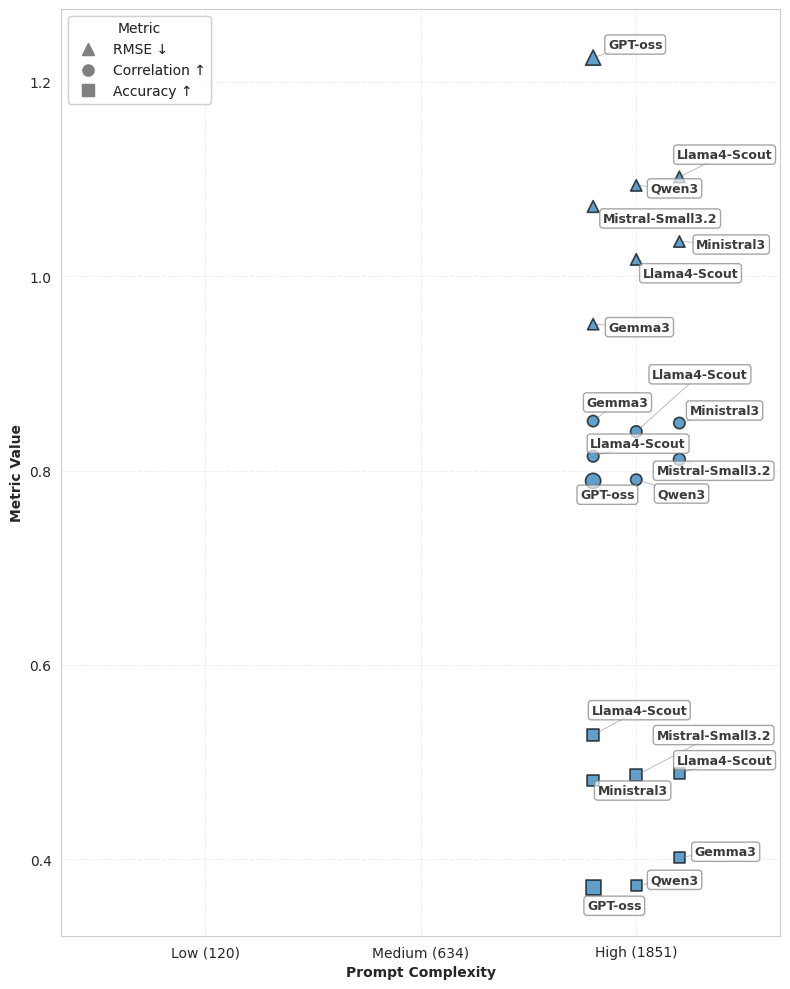

In [41]:
# plot_model_metrics_scatter(
#     df=df_metrics,
#     metric_column="correlation",
#     ylabel="Correlation",
#     min_threshold=0.1,
#     y_padding=0.05,
#     figsize=(6, 8),
#     shorten_model_names=False,
# )
# plot_model_metrics_scatter(
#     df=df_metrics,
#     metric_column="rmse",
#     ylabel="RMSE",
#     min_threshold=0.1,
#     y_padding=0.025,
#     figsize=(6, 8),
#     shorten_model_names=True,
# )
# plot_model_metrics_scatter(
#     df=df_metrics,
#     metric_column="accuracy",
#     ylabel="Accuracy",
#     min_threshold=0.1,
#     y_padding=0.025,
#     figsize=(6, 8),
#     shorten_model_names=True,
# )

plot_model_metrics_combined_scatter(
    df=df_metrics,
    min_threshold=0.1,
    y_padding=0.05,
    figsize=(8, 10),
    shorten_model_names=True,
    show_labels=True,
)

### Model Summary

In [42]:
summary_table = df_metrics.pivot_table(
    index="model_name",
    columns="prompt",
    values=["correlation", "rmse", "accuracy", "throughput", "error_rate"],
    aggfunc="first",
)

print("Correlation Summary:")
print("=" * 80)
print(summary_table["correlation"].round(3))

print("\n\nRMSE Summary:")
print("=" * 80)
print(summary_table["rmse"].round(3))

print("\n\nAccuracy Summary:")
print("=" * 80)
print(summary_table["accuracy"].round(3))

print("\n\nThroughput Summary (predictions/sec):")
print("=" * 80)
print(summary_table["throughput"].round(3))

print("\n\nError Rate Summary (%):")
print("=" * 80)
print(summary_table["error_rate"].round(1))

Correlation Summary:
prompt                Rate each text segment on a scale from 0-5, where higher numbers indicate greater visual descriptiveness. Select the **highest applicable rating** found in the segment.\n\n## Rating Scale\n\n**Rating 5** - Full vivid scene\n- Can visualize a complete scene with vivid background, foreground objects, and compelling details (e.g., time of day, lighting, atmospheric conditions)\n- Example: "The sun was setting behind the mountains, casting long shadows over the bustling village square where children played and vendors packed up their stalls."\n\n**Rating 4** - Full scene with details OR detailed character\n- **Option A (Scene)**: Can visualize a full scene with multiple elements - must have at least 3 of:\n  1. Background/surroundings\n  2. Action/main scene\n  3. Describable character(s)\n  4. Other visual details (each distinct detail counts separately)\n  - Example: "A river flowed through the meadow, with a few trees scattered along its banks 

### Overall Model Ranking

In [43]:
overall_ranking = (
    df_metrics.groupby("model_name")
    .agg(
        {
            "correlation": "mean",
            "rmse": "mean",
            "accuracy": "mean",
            "throughput": "mean",
            "error_rate": "mean",
        }
    )
    .round(3)
    .sort_values("correlation", ascending=False)
)

print("\nOverall Model Rankings (Average across all prompts):")
print("=" * 80)
print(overall_ranking)


Overall Model Rankings (Average across all prompts):
                      correlation   rmse  accuracy  throughput  error_rate
model_name                                                                
Gemma3-12b                  0.851  0.951     0.402      16.830       0.000
Ministral3-14b              0.849  1.036     0.481      56.446       0.000
Llama4-Scout-17b            0.827  1.060     0.508      20.411       0.000
Mistral-Small3.2-24b        0.812  1.072     0.486      35.981       0.000
Qwen3-14b                   0.791  1.093     0.373      59.954       0.000
GPT-oss-120b                0.789  1.225     0.371       0.258       2.466


## Prompt Table

In [44]:
df_table = build_prompt_configuration_table(df_metrics)

# Generate LaTeX table
latex_table = df_table.to_latex(
    index=False,
    escape=False,
    caption="Prompt Configuration Evaluation Results",
    label="tab:prompt_configs",
)
print(latex_table)

# Also display as formatted table for quick review
print("\n\nFormatted Table:")
print(df_table.to_string(index=False))

\begin{table}
\caption{Prompt Configuration Evaluation Results}
\label{tab:prompt_configs}
\begin{tabular}{rllllll}
\toprule
\textbf{#} & Task Descr. & \textbf{Examples} & \textbf{CoT} & \textbf{CORR} & \textbf{RMSE} & \textbf{ACC} \\
\midrule
1 & Short &  &  &  &  &  \\
2 & Short &  & zero-shot &  &  &  \\
3 & Short & yes &  &  &  &  \\
4 & Short & yes & zero-shot &  &  &  \\
5 & Expanded &  &  &  &  &  \\
6 & Expanded &  & zero-shot &  &  &  \\
7 & Expanded & yes &  &  &  &  \\
8 & Expanded & yes & zero-shot &  &  &  \\
9 & Expanded & yes & few-shot &  &  &  \\
10 & Full &  &  &  &  &  \\
11 & Full &  & zero-shot &  &  &  \\
12 & Full & yes &  & \textbf{0.851} & \textbf{0.951} & \textbf{0.528} \\
13 & Full & yes & zero-shot &  &  &  \\
14 & Full & yes & few-shot &  &  &  \\
\bottomrule
\end{tabular}
\end{table}



Formatted Table:
 \textbf{#} Task Descr. \textbf{Examples} \textbf{CoT}  \textbf{CORR}  \textbf{RMSE}   \textbf{ACC}
          1       Short                                

## Load Configs

In [52]:
# Load all metric files
metric_files = sorted(METRICS_DIR.glob("*.json"))
items = load_metric_files(metric_files)

config_names = [item.get("prompt_id", f"config_{i}") for i, item in enumerate(items)]

print(f"Available configurations ({len(config_names)}):")
for idx, name in enumerate(config_names):
    print(f"  {idx}: {name}")

Available configurations (1):
  0: few-shot_no-cot_Rate-each-


## Metrics vs Prompt Token Count

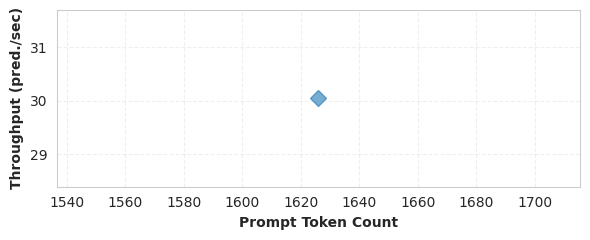

In [53]:
fig, ax, df_grouped = plot_metrics_vs_prompt_token_count(
    df_metrics=df_metrics,
    items=items,
    figsize=(6, 2.5),
    metrics_to_plot=["throughput"],
    normalize_throughput=False,
    y_label="Throughput (pred./sec)",
    show_legend=False,
)

## Post-optimization Table

In [54]:
SELECTED_CONFIG_IDX = 0
SELECTED_MODEL_NAME = "Llama4-Scout-17b"

PRE_OPTIMIZATION_DIR = METRICS_DIR / "pre-optimization"

# Load pre-optimization metrics
pre_optim_metric_files = sorted(PRE_OPTIMIZATION_DIR.glob("*.json"))
print(f"Found {len(pre_optim_metric_files)} pre-optimization metric files")

pre_optim_metrics = []
for metric_file in pre_optim_metric_files:
    try:
        model_metrics = extract_model_metrics(metric_file)
        pre_optim_metrics.extend(model_metrics)
    except Exception as e:
        print(f"✗ Error processing {metric_file.name}: {e}")

df_pre_optim = pd.DataFrame(pre_optim_metrics)

# Compute comparison table
df_comparison_table = compute_optimization_comparison_table(
    df_current=df_metrics,
    df_pre_optim=df_pre_optim,
    selected_config_idx=SELECTED_CONFIG_IDX,
    config_names=config_names,
    selected_model_name=SELECTED_MODEL_NAME,
)

print(
    f"\nOptimization Comparison for Config {SELECTED_CONFIG_IDX}: {config_names[SELECTED_CONFIG_IDX]}"
)
print("=" * 100)
print(df_comparison_table.round(4).to_string(index=False))

# Generate LaTeX table with colored deltas
latex_table = format_optimization_comparison_latex(df_comparison_table)

# Display the LaTeX table
print(latex_table)

Found 15 pre-optimization metric files

Optimization Comparison for Config 0: few-shot_no-cot_Rate-each-
        Model   CORR  Δ CORR   RMSE  Δ RMSE    ACC   Δ ACC
    Optimized 0.8402 -0.0052 1.0173  0.0271 0.5281 -0.0051
Avg-of-Others 0.8183 -0.0067 1.0753  0.0472 0.4229 -0.0195
\begin{tabular}{lllllll}
\toprule
\textbf{Model} & \textbf{CORR} & \textbf{Δ CORR} & \textbf{RMSE} & \textbf{Δ RMSE} & \textbf{ACC} & \textbf{Δ ACC} \\
\midrule
Optimized & 0.840 & \textcolor{red}{-0.005} & 1.017 & \textcolor{red}{+0.027} & 0.528 & \textcolor{red}{-0.005} \\
Avg-of-Others & 0.818 & \textcolor{red}{-0.007} & 1.075 & \textcolor{red}{+0.047} & 0.423 & \textcolor{red}{-0.019} \\
\bottomrule
\end{tabular}



<string>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.840' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
<string>:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.017' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
<string>:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.528' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
<string>:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textcolor{red}{-0.005}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
<string>:43: FutureWarning: Se

## Model Evaluation with Core Visualization

In [55]:
SELECTED_CONFIG_IDX = 0
SELECTED_MODEL_NAME = "Llama4-Scout-17b"
print(f"Selected configuration: {config_names[SELECTED_CONFIG_IDX]}")

df_train, df_test = load_train_test_data(DATA_DIR)
score_data = to_llm_score_data(items, df_train, df_test)
filtered_score_data = [sd for sd in score_data if sd.config_id == SELECTED_CONFIG_IDX]
selected_model_data = next(
    (sd for sd in filtered_score_data if sd.model_name == SELECTED_MODEL_NAME),
    None,
)

available_models = [sd.model_name for sd in filtered_score_data]
print(f"Configuration: Config {SELECTED_CONFIG_IDX}")
print(f"Selected model: {SELECTED_MODEL_NAME}")
print(f"Available models: {available_models}")

multiple_models = []
for sd in filtered_score_data:
    train_outputs = (
        to_int_0_5(sd.train_scores)
        if sd.train_scores is not None and sd.train_scores.size > 0
        else None
    )
    test_outputs = (
        to_int_0_5(sd.test_scores)
        if sd.test_scores is not None and sd.test_scores.size > 0
        else None
    )

    if train_outputs is not None or test_outputs is not None:
        converted = llm_metrics_to_core(
            predictions=train_outputs,
            labels=sd.y_train if train_outputs is not None else None,
            test_predictions=test_outputs,
            test_labels=sd.y_test if test_outputs is not None else None,
            model_name=sd.model_name,
        )
        multiple_models.append(converted)

print(
    f"Loaded {len(multiple_models)} model(s) from configuration {SELECTED_CONFIG_IDX}"
)
for m in multiple_models:
    train_status = "✓" if m.train is not None else "✗"
    test_status = "✓" if m.test is not None else "✗"
    print(f"  - {m.model} [Train: {train_status}, Test: {test_status}]")

Selected configuration: few-shot_no-cot_Rate-each-
Configuration: Config 0
Selected model: Llama4-Scout-17b
Available models: ['Llama4-Scout-17b', 'Gemma3-12b', 'GPT-oss-120b', 'Ministral3-14b', 'Qwen3-14b', 'Mistral-Small3.2-24b']
Loaded 6 model(s) from configuration 0
  - Llama4-Scout-17b [Train: ✓, Test: ✓]
  - Gemma3-12b [Train: ✓, Test: ✗]
  - GPT-oss-120b [Train: ✓, Test: ✗]
  - Ministral3-14b [Train: ✓, Test: ✗]
  - Qwen3-14b [Train: ✓, Test: ✗]
  - Mistral-Small3.2-24b [Train: ✓, Test: ✗]


/home/terra/Projects/vis-desc/modules/lab/src/evaluation/llm/interface.py:28: RuntimeWarning: invalid value encountered in cast
  return np.clip(np.round(values), 0, 5).astype(int)


### Confusion Matrices



TRAIN SET CONFUSION MATRIX


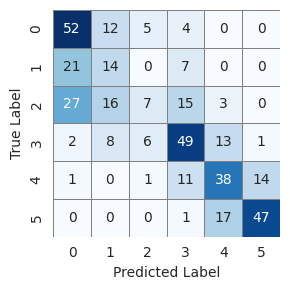


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 207
  Incorrect predictions (off-diagonal): 185
  Accuracy: 0.5281

Per-label statistics:
  Label 0: 52/73 correct (71.23%)
  Label 1: 14/42 correct (33.33%)
  Label 2: 7/68 correct (10.29%)
  Label 3: 49/79 correct (62.03%)
  Label 4: 38/65 correct (58.46%)
  Label 5: 47/65 correct (72.31%)

TEST SET CONFUSION MATRIX


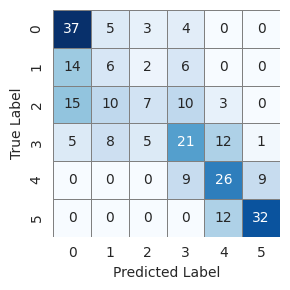


Confusion Matrix Statistics:
  Total predictions: 262
  Correct predictions (diagonal): 129
  Incorrect predictions (off-diagonal): 133
  Accuracy: 0.4924

Per-label statistics:
  Label 0: 37/49 correct (75.51%)
  Label 1: 6/28 correct (21.43%)
  Label 2: 7/45 correct (15.56%)
  Label 3: 21/52 correct (40.38%)
  Label 4: 26/44 correct (59.09%)
  Label 5: 32/44 correct (72.73%)


In [56]:
if selected_model_data is None:
    print(
        f"Selected model {SELECTED_MODEL_NAME} not found in configuration {SELECTED_CONFIG_IDX}"
    )
else:
    conf_model = llm_metrics_to_core(
        predictions=to_int_0_5(selected_model_data.train_scores)
        if selected_model_data.train_scores is not None
        and selected_model_data.train_scores.size > 0
        else None,
        labels=selected_model_data.y_train
        if selected_model_data.train_scores is not None
        and selected_model_data.train_scores.size > 0
        else None,
        test_predictions=to_int_0_5(selected_model_data.test_scores)
        if selected_model_data.test_scores is not None
        and selected_model_data.test_scores.size > 0
        else None,
        test_labels=selected_model_data.y_test
        if selected_model_data.test_scores is not None
        and selected_model_data.test_scores.size > 0
        else None,
        model_name=selected_model_data.model_name,
    )
    vis_specific_model_conf_matrices(
        conf_model, show_proportional=False, show_title=False
    )

### Multiple Models Comparison


#### Per-label metrics and model comparison plots

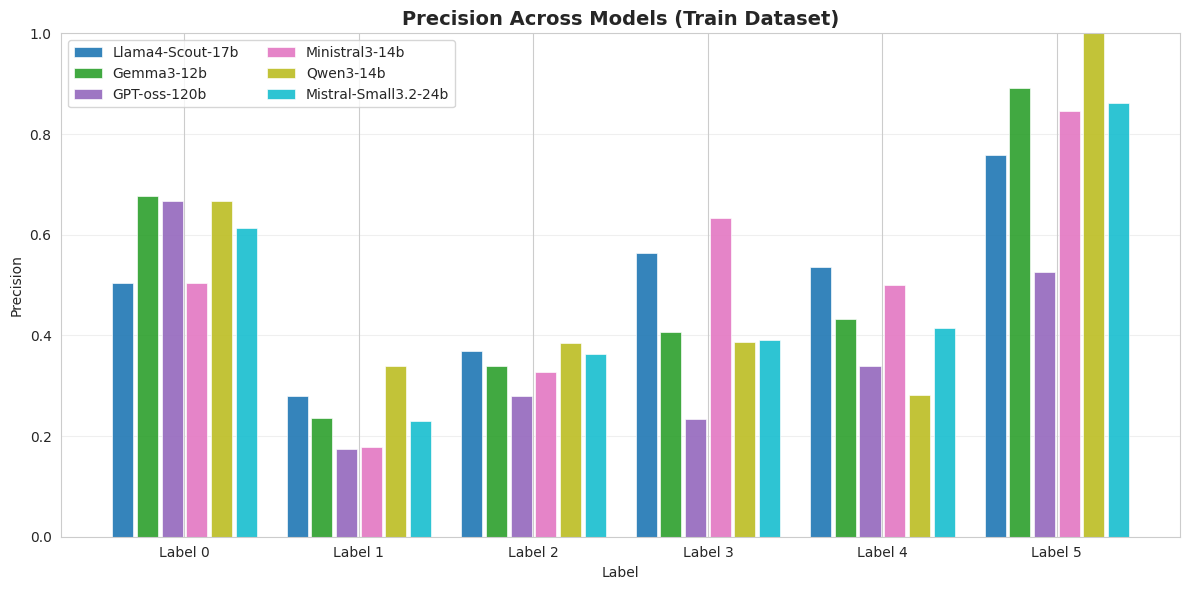

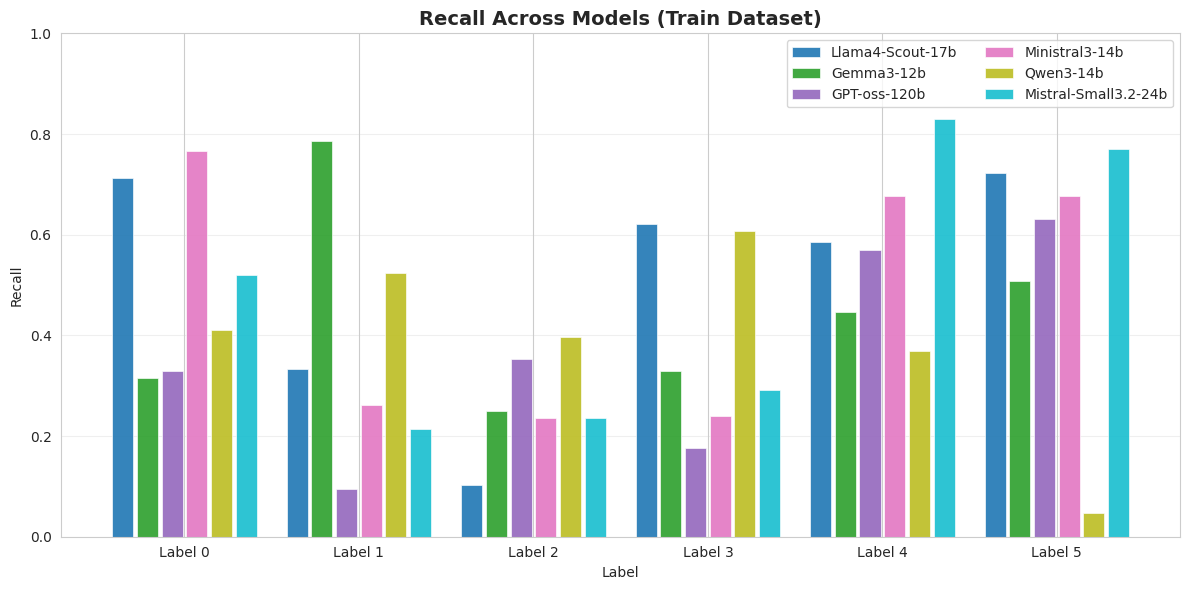

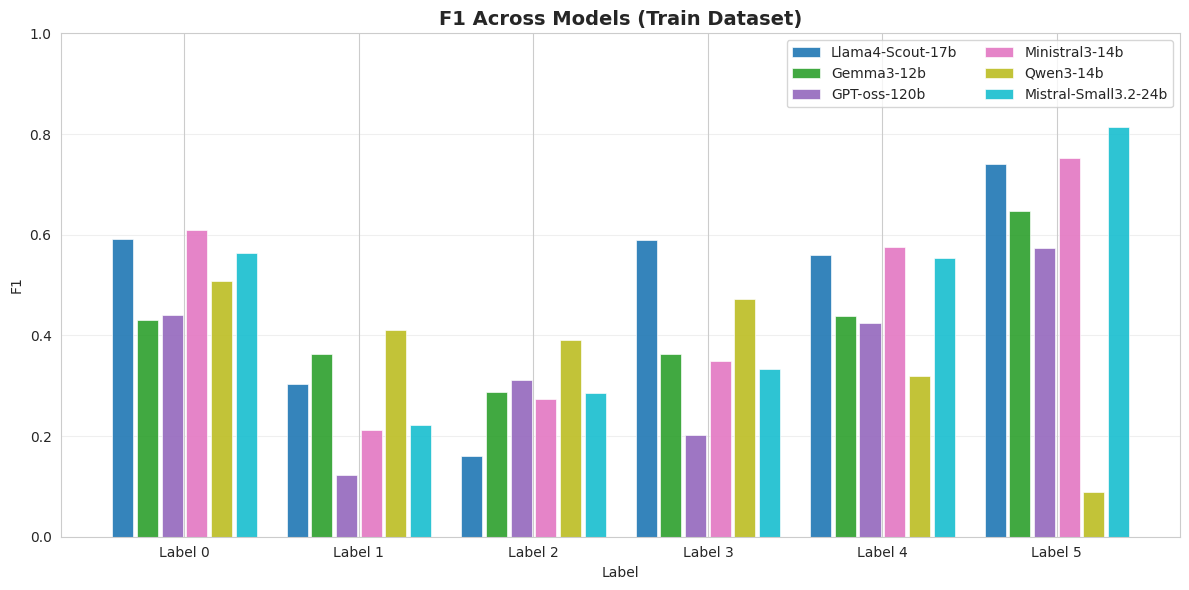

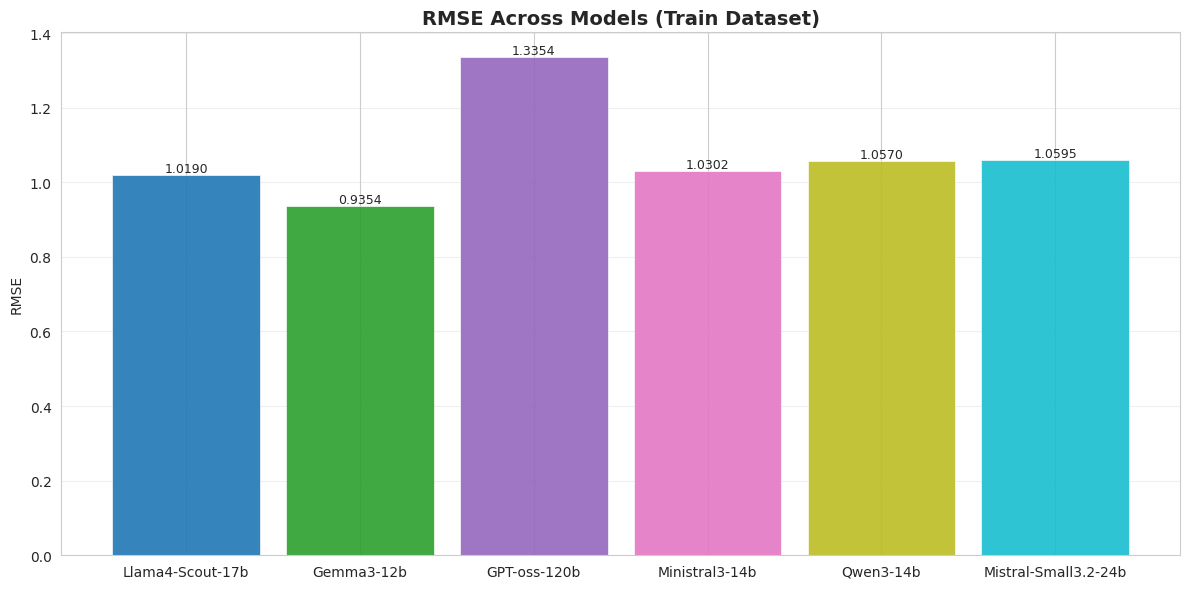

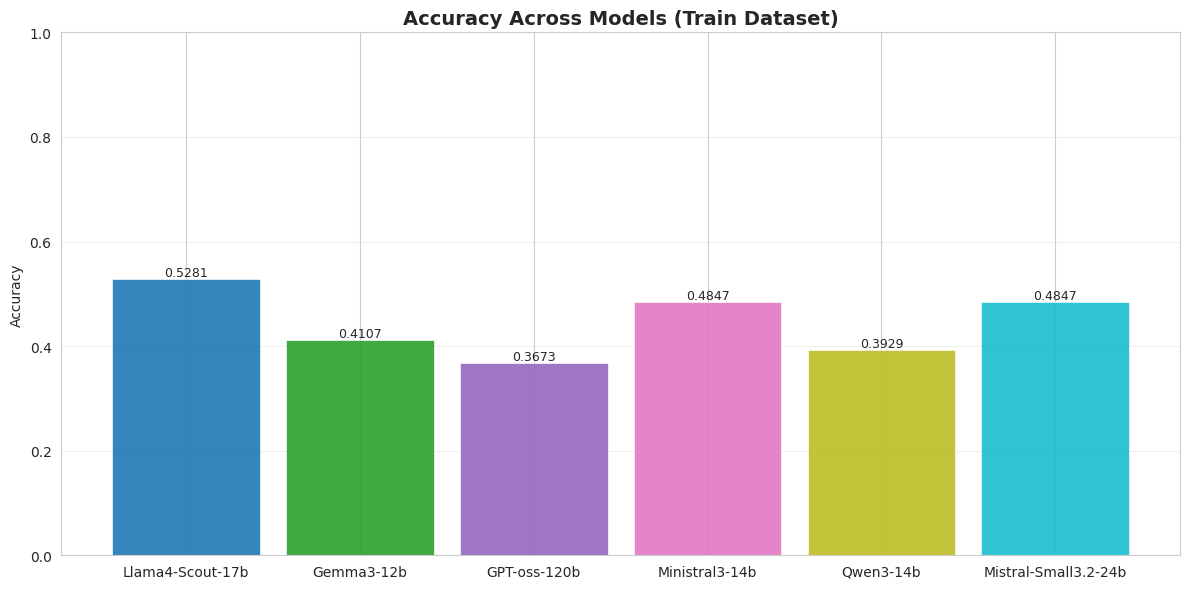

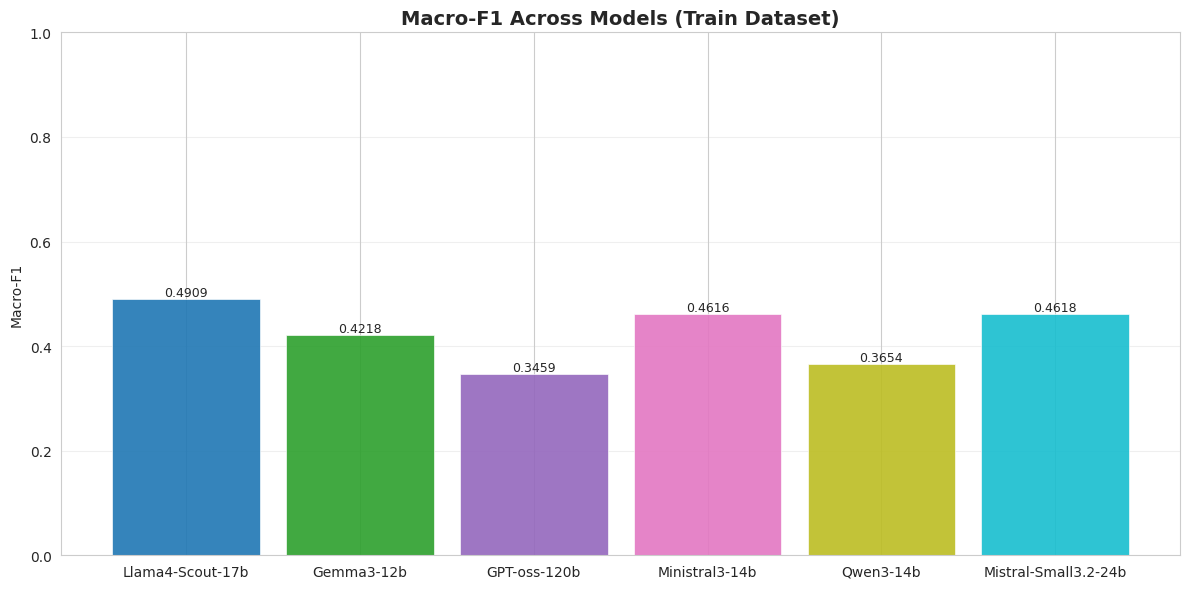

In [50]:
if multiple_models:
    vis_all_models_plots(multiple_models, "train")

## Relaxed Class Mode (merge 0/1, 2/3, 4/5)

These evaluations recompute metrics and confusion matrices after collapsing labels into three classes.



TRAIN SET CONFUSION MATRIX


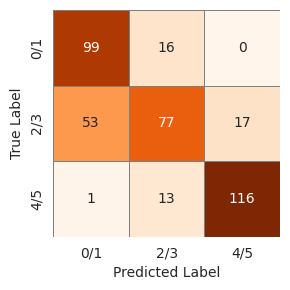


Confusion Matrix Statistics:
  Total predictions: 392
  Correct predictions (diagonal): 292
  Incorrect predictions (off-diagonal): 100
  Accuracy: 0.7449

Per-label statistics:
  Label 0: 99/115 correct (86.09%)
  Label 1: 77/147 correct (52.38%)
  Label 2: 116/130 correct (89.23%)

TEST SET CONFUSION MATRIX


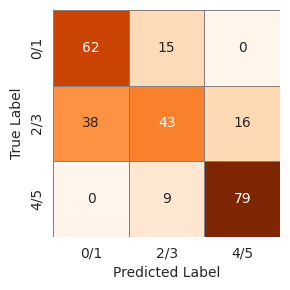


Confusion Matrix Statistics:
  Total predictions: 262
  Correct predictions (diagonal): 184
  Incorrect predictions (off-diagonal): 78
  Accuracy: 0.7023

Per-label statistics:
  Label 0: 62/77 correct (80.52%)
  Label 1: 43/97 correct (44.33%)
  Label 2: 79/88 correct (89.77%)


In [57]:
filtered_score_data_relaxed = [
    sd for sd in filtered_score_data if sd.config_id == SELECTED_CONFIG_IDX
]
if filtered_score_data_relaxed:
    sd_relaxed = filtered_score_data_relaxed[0]
    relaxed_conf_model = llm_metrics_to_core(
        predictions=to_int_0_5(sd_relaxed.train_scores)
        if sd_relaxed.train_scores is not None and sd_relaxed.train_scores.size > 0
        else None,
        labels=sd_relaxed.y_train
        if sd_relaxed.train_scores is not None and sd_relaxed.train_scores.size > 0
        else None,
        test_predictions=to_int_0_5(sd_relaxed.test_scores)
        if sd_relaxed.test_scores is not None and sd_relaxed.test_scores.size > 0
        else None,
        test_labels=sd_relaxed.y_test
        if sd_relaxed.test_scores is not None and sd_relaxed.test_scores.size > 0
        else None,
        model_name=sd_relaxed.model_name,
    )
    vis_specific_model_conf_matrices(
        relaxed_conf_model,
        show_proportional=False,
        show_title=False,
        class_mode="relaxed",
    )
else:
    print(f"No models found for configuration {SELECTED_CONFIG_IDX}")

In [ ]:
vis_all_models_plots(multiple_models, dataset="train", class_mode="relaxed")

In [19]:
model_names = [m.model for m in multiple_models]
model_groups, show_large_variants = get_llm_model_groups(model_names)
df_metrics_relaxed = vis_all_models_tables(
    multiple_models,
    ["Acc"],
    ["Train", "Test"],
    model_groups,
    show_large_variants,
    class_mode="relaxed",
)
latex_table_relaxed = format_metrics_for_latex(df_metrics_relaxed)
print(latex_table_relaxed)

,Model,Train Acc,Test Acc
0,Llama4-Scout-17b,0.7449,
1,Gemma3-12b,0.7041,
2,GPT-oss-120b,0.5918,
3,Ministral3-14b,0.7041,
4,Qwen3-14b,0.6760,
5,Mistral-Small3.2-24b,0.6786,


\begin{tabular}{rrr}
\toprule
\textbf{Model} & \textbf{Train Acc} & \textbf{Test Acc} \\
\midrule
Llama4-Scout-17b & \textbf{0.7449} &  \\
Gemma3-12b & 0.7041 &  \\
GPT-oss-120b & 0.5918 &  \\
Ministral3-14b & 0.7041 &  \\
Qwen3-14b & 0.6760 &  \\
Mistral-Small3.2-24b & 0.6786 &  \\
\bottomrule
\end{tabular}



/home/terra/Projects/vis-desc/modules/lab/src/evaluation/core.py:922: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\textbf{0.7449}' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_latex.loc[idx, col] = (


### Scale Comparison: Normal vs Relaxed

In [62]:
# Generate scale comparison table for selected configuration
df_comparison, metrics, model_name = generate_scale_comparison_output(
    filtered_score_data, SELECTED_CONFIG_IDX, to_int_0_5, llm_metrics_to_core
)

if df_comparison is not None:
    print(f"\nTest Set Metrics for {model_name}:")
    print("=" * 50)
    print(df_comparison.to_string(index=False))
    print("\n")

    # LaTeX version
    latex_comparison = df_comparison.to_latex(
        index=False,
        escape=False,
        caption=f"Test Set Metrics Comparison: Normal vs Relaxed Scale ({model_name})",
        label="tab:scale_comparison",
    )
    print(latex_comparison)
elif model_name:
    print(f"No test set data available for {model_name}.")
else:
    print(f"No models found for configuration {SELECTED_CONFIG_IDX}")


Test Set Metrics for Llama4-Scout-17b:
\textbf{Scale} \textbf{RMSE} \textbf{Accuracy}
        Normal        1.0930            0.4924
       Relaxed        0.5456            0.7023


\begin{table}
\caption{Test Set Metrics Comparison: Normal vs Relaxed Scale (Llama4-Scout-17b)}
\label{tab:scale_comparison}
\begin{tabular}{lll}
\toprule
\textbf{Scale} & \textbf{RMSE} & \textbf{Accuracy} \\
\midrule
Normal & 1.0930 & 0.4924 \\
Relaxed & 0.5456 & 0.7023 \\
\bottomrule
\end{tabular}
\end{table}

